In [4]:
import pandas as pd
import os
os.chdir("/home/yangkai/codegen-detection")

In [2]:
hum_data = pd.read_pickle("dataset/apps_hum_test.pkl")
gen_data = pd.read_pickle("dataset/apps_gen_test_wizard.pkl")

In [20]:
hum_data100 = hum_data.sample(n=100,random_state=42)
gen_data100 = gen_data.sample(n=100,random_state=42)

hum_data100.to_pickle("dataset/mbpp_hum_test100.pkl")
gen_data100.to_pickle("dataset/mbpp_gen_test100.pkl")


In [20]:
for key in gen_data.keys():
    if "extracted_full_func-nocot" in key:
        print(key)

extracted_full_func-nocot
extracted_full_func-nocot_word_prob_starcoder
extracted_full_func-nocot_word_rank_starcoder
extracted_full_func-nocot_entropy_starcoder
extracted_full_func-nocot_word_prob_llama-13b
extracted_full_func-nocot_word_rank_llama-13b
extracted_full_func-nocot_entropy_llama-13b
extracted_full_func-nocot_word_prob_incoder-6B
extracted_full_func-nocot_word_rank_incoder-6B
extracted_full_func-nocot_entropy_incoder-6B
extracted_full_func-nocot_word_prob_codegen-2B-mono
extracted_full_func-nocot_word_rank_codegen-2B-mono
extracted_full_func-nocot_entropy_codegen-2B-mono


In [9]:
h_dset = "mbpp_hum_test"
g_dset = "mbpp_gen_test_wizard"
hum_data = pd.read_pickle(f"dataset/{h_dset}.pkl")
gen_data = pd.read_pickle(f"dataset/{g_dset}.pkl")
hum_data['label'] = 0
gen_data['label'] = 1

/tmp/ipykernel_1190269/541142133.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hum_data['label'] = 0


In [11]:
import json
# hum_perturb = json.load(open(f"dataset/{h_dset}_perturb_100.json",'r'))
gen_perturb = json.load(open(f"dataset/{g_dset}_perturb_100.json",'r'))
len(hum_perturb),len(gen_perturb)

(77000, 23300)

In [13]:
# pids = []
# for id in hum_data.problem_id:
#     pids += [id] * 100
# hum_perturb_df = {"extracted_full_func":hum_perturb,"pid":pids}
# hum_perturb_df = pd.DataFrame(hum_perturb_df)

In [14]:
pids = []
for id in gen_data.problem_id:
    pids += [id] * 100
gen_perturb_df = {"extracted_full_func":gen_perturb,"pid":pids}
gen_perturb_df = pd.DataFrame(gen_perturb_df)

In [15]:
# hum_perturb_df = hum_perturb_df[hum_perturb_df.extracted_full_func.apply(len) > 0]
gen_perturb_df = gen_perturb_df[gen_perturb_df.extracted_full_func.apply(len) > 0]
len(hum_perturb_df),len(gen_perturb_df)

(2, 23200)

In [16]:
gen_perturb_df.to_pickle(f"dataset/{g_dset}_perturb_100.pkl")
# hum_perturb_df.to_pickle(f"dataset/{h_dset}_perturb_100.pkl")

### Gather Baselines

In [4]:
from sklearn.metrics import roc_auc_score,average_precision_score
import numpy as np

def word_prob_gather_fn(word_prob):
    try:
        assert len(word_prob) > 0
    except:
        return 0
    if model != 'code-cushman-001':
        log_prob = np.log(np.array(word_prob) + 1e-6)
    else:
        log_prob = np.array(word_prob)
    avg_log_prob = log_prob.sum() / (len(log_prob) + 1e-6)
    # print(avg_log_prob)
    return avg_log_prob

def entropy_gather_fn(entropy):
    try:
        assert len(entropy) > 0
    except:
        return 0
    entropy = np.array(entropy)
    
    avg_entropy = entropy.sum() / (len(entropy) + 1e-6)
    return -avg_entropy

def log_rank_gather_fn(word_rank):
    try:
        assert len(word_rank) > 0
    except:
        return 0
    log_rank = np.log(np.array(word_rank) + 1)
    avg_log_rank = log_rank.sum() / (len(log_rank) + 1e-6)
    return -avg_log_rank

def rank_gather_fn(word_rank):
    try:
        assert len(word_rank) > 0
    except:
        return 0
    log_rank = np.array(word_rank) + 1
    avg_log_rank = log_rank.sum() / (len(log_rank) + 1e-6)
    return -avg_log_rank

def lpr_gather_fn(row,word_rank_name,word_prob_name):
    word_rank = row[word_rank_name]
    word_prob = row[word_prob_name]
    assert(len(word_prob) == len(word_rank))
    try:
        assert len(word_rank) > 0
    except:
        return 0
    log_rank = np.log(np.array(word_rank) + 1e-6)

    try:
        assert len(word_prob) > 0
    except:
        return 0
    if model != 'code-cushman-001':
        log_prob = np.log(np.array(word_prob) + 1e-6)
    else:
        log_prob = np.array(word_prob)

    return - log_prob.sum() / (log_rank.sum() + 1e-6)
    


dset = "apps"
generator = '_codellama'
gen_data = pd.read_pickle(f"dataset/{dset}_gen_test{generator}.pkl")
# correct_ids = pd.read_pickle("dataset/mbpp_gen_test_correct.pkl")['problem_id'].tolist()
# gen_data = gen_data[~gen_data.problem_id.isin(correct_ids)]
# hum_data = pd.read_pickle("dataset/mbpp_hum_test.pkl").sample(n=len(gen_data),random_state=42)
hum_data = pd.read_pickle(f"dataset/{dset}_hum_test.pkl")

hum_data['label'] = 0
gen_data['label'] = 1

hum_column_prefix = 'extracted_full_func_'
gen_column_prefix = 'extracted_full_func_'

all_data = pd.concat([gen_data,hum_data])
# models = ['codegen-2B-mono','incoder-6B','llama-13b','starcoder','vicuna-7b','vicuna-13b']
# models = ['starchat-alpha','CodeLlama-13b-Instruct-hf']
models = ['CodeLlama-13b-Instruct-hf','starchat-alpha']

# models = ['PolyCoder-160M']

score_names = ['log_prob','log_rank','rank','entropy']
# score_names = []

# score_names = ['rank']
feat_name_dict = {'log_prob':"word_prob","rank":"word_rank","log_rank":"word_rank","entropy":"entropy"}
name2gatherfn = {"log_prob":word_prob_gather_fn,"rank":rank_gather_fn,"log_rank":log_rank_gather_fn,"entropy":entropy_gather_fn}
result_df = pd.DataFrame(index=score_names+['lpr'],columns=models)
for model in models:
    for score in score_names:
        # print(model,score)
        hum_column_name = hum_column_prefix + f"{feat_name_dict[score]}_{model}"
        gen_column_name = gen_column_prefix + f"{feat_name_dict[score]}_{model}"
        
        all_feat = pd.concat([gen_data[gen_column_name],hum_data[hum_column_name]])

        all_score = all_feat.apply(name2gatherfn[score]).tolist()
        all_label = all_data['label']
        roc = roc_auc_score(all_label,all_score)
        result_df[model][score] = roc
    
    # Add LPR score
    hum_wordrank_column_name = hum_column_prefix + f"word_rank_{model}"
    hum_wordprob_column_name = hum_column_prefix + f"word_prob_{model}"
    gen_wordrank_column_name = gen_column_prefix + f"word_rank_{model}"
    gen_wordprob_column_name = gen_column_prefix + f"word_prob_{model}"
    hum_lpr = hum_data.apply(lambda row: lpr_gather_fn(row,hum_wordrank_column_name,hum_wordprob_column_name),axis=1)
    gen_lpr = gen_data.apply(lambda row: lpr_gather_fn(row,gen_wordrank_column_name,gen_wordprob_column_name),axis=1)
    # hum_lpr = hum_data[hum_wordprob_column_name].apply(word_prob_gather_fn) / hum_data[hum_wordrank_column_name].apply(log_rank_gather_fn)
    # gen_lpr = gen_data[gen_wordrank_column_name].apply(word_prob_gather_fn) / gen_data[gen_wordprob_column_name].apply(log_rank_gather_fn)

    all_score = pd.concat([gen_lpr,hum_lpr])
    # print(all_score)
    all_label = all_data['label']
    roc = roc_auc_score(all_label,all_score)
    result_df[model]['lpr'] = roc

result_df['avg'] = result_df.mean(axis=1)

In [5]:
result_df

,CodeLlama-13b-Instruct-hf,starchat-alpha,avg
log_prob,0.66141,0.664088,0.662749
log_rank,0.627148,0.612746,0.619947
rank,0.521736,0.538533,0.530135
entropy,0.58913,0.565493,0.577312
lpr,0.671564,0.665537,0.66855


In [11]:

gen_data['extracted_full_func_entropy_starcoder'].apply(np.mean).mean()

1.2726708342586461

In [46]:
hum_perturb = pd.read_pickle("dataset/apps_hum_test_perturb_100.pkl")

In [49]:
for key in hum_perturb.columns:
    print(key)

extracted_full_func
pid
extracted_full_func_word_prob_starcoder
extracted_full_func_word_rank_starcoder
extracted_full_func_entropy_starcoder
extracted_full_func_word_prob_llama-13b
extracted_full_func_word_rank_llama-13b
extracted_full_func_entropy_llama-13b
extracted_full_func_word_prob_incoder-6B
extracted_full_func_word_rank_incoder-6B
extracted_full_func_entropy_incoder-6B
extracted_full_func_word_prob_codegen-2B-mono
extracted_full_func_word_rank_codegen-2B-mono
extracted_full_func_entropy_codegen-2B-mono
extracted_full_func_word_prob_vicuna-7b
extracted_full_func_word_rank_vicuna-7b
extracted_full_func_entropy_vicuna-7b
extracted_full_func_word_prob_vicuna-13b
extracted_full_func_word_rank_vicuna-13b
extracted_full_func_entropy_vicuna-13b


### Gather DetectGPT

In [16]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import roc_auc_score,average_precision_score

def word_prob_gather_fn_with_trunc(word_prob,ratio=0):
    try:
        assert len(word_prob) > 0
    except:
        return 0
    if model != 'code-cushman-001':
        log_prob = np.log(np.array(word_prob) + 1e-6)
    else:
        log_prob = np.array(word_prob)
    
    # log_prob = np.array(word_prob)

    log_prob = log_prob[int(len(log_prob) * ratio):]
    avg_log_prob = log_prob.sum() / (len(log_prob) + 1e-6)
    # print(avg_log_prob)
    return avg_log_prob

# models = ['starchat-alpha','CodeLlama-13b-Instruct-hf']
models = ['CodeLlama-13b-Instruct-hf','starchat-alpha']

# models = ['PolyCoder-160M']

dset = 'mbpp'
generator = ''

gen_data = pd.read_pickle(f"dataset/{dset}_gen_test{generator}.pkl")
# correct_ids = pd.read_pickle("dataset/mbpp_gen_test_correct.pkl")['problem_id'].tolist()
# gen_data = gen_data[gen_data.problem_id.isin(correct_ids)]

hum_data = pd.read_pickle(f"dataset/{dset}_hum_test.pkl")
# hum_data = pd.read_pickle("dataset/mbpp_hum_test.pkl").sample(n=len(gen_data),random_state=42)
# subset = pd.read_pickle("dataset/apps_hum_test.pkl")
# hum_data = hum_data[hum_data.problem_id.isin(subset.problem_id.tolist())]

hum_data['label'] = 0
gen_data['label'] = 1

hum_perturb = pd.read_pickle(f"dataset/{dset}_hum_test_perturb_100.pkl")
gen_perturb = pd.read_pickle(f"dataset/{dset}_gen_test{generator}_perturb_100.pkl")
df = pd.DataFrame(index=['DetectGPT','NPR'],columns=models)
for model in models:
    column_name = f"extracted_full_func_word_prob_{model}"
    hum_score = []
    hum_npr = []
    for _,row in hum_data.iterrows():
        pid,orig_prob,orig_rank = row['problem_id'],row[f"extracted_full_func_word_prob_{model}"],row[f"extracted_full_func_word_rank_{model}"]
        perturb_rows = hum_perturb[hum_perturb.pid == pid]

        orig_prob = word_prob_gather_fn_with_trunc(orig_prob)
        perturb_probs = perturb_rows[f"extracted_full_func_word_prob_{model}"].apply(word_prob_gather_fn_with_trunc)
        orig_rank = - log_rank_gather_fn(orig_rank)
        perturb_ranks = perturb_rows[f"extracted_full_func_word_rank_{model}"].apply(log_rank_gather_fn)

        if len(perturb_probs) == 0:
            hum_score.append(0)
            hum_npr.append(0)
            continue
        perturb_prob = perturb_probs.mean()
        perturb_prob_std = np.std([i for i in perturb_probs if not math.isnan(i)]) if len([i for i in perturb_probs if not math.isnan(i)]) > 1 else 1
        prob_diff = orig_prob - perturb_prob
        if perturb_prob_std == 0:
            perturb_prob_std = 1
        # ADD std
        hum_score.append(prob_diff/perturb_prob_std)

        perturb_rank = - perturb_ranks.mean()
        npr = perturb_rank / orig_rank
        hum_npr.append(npr)


    
    gen_score = []
    gen_npr = []
    for _,row in gen_data.iterrows():
        pid,orig_prob,orig_rank = row['problem_id'],row[f"extracted_full_func_word_prob_{model}"],row[f"extracted_full_func_word_rank_{model}"]
        perturb_rows = gen_perturb[gen_perturb.pid == pid]


        orig_prob = word_prob_gather_fn_with_trunc(orig_prob)
        perturb_probs = perturb_rows[f"extracted_full_func_word_prob_{model}"].apply(word_prob_gather_fn_with_trunc)
        orig_rank = - log_rank_gather_fn(orig_rank)
        perturb_ranks = perturb_rows[f"extracted_full_func_word_rank_{model}"].apply(log_rank_gather_fn)
        if len(perturb_probs) == 0:
            gen_score.append(0)
            gen_npr.append(0)
            continue
        perturb_prob = perturb_probs.mean()
        perturb_prob_std = np.std([i for i in perturb_probs if not math.isnan(i)]) if len([i for i in perturb_probs if not math.isnan(i)]) > 1 else 1
        if perturb_prob_std == 0:
            perturb_prob_std = 1
        prob_diff = orig_prob - perturb_prob
        # ADD std
        gen_score.append(prob_diff/perturb_prob_std)

        perturb_rank = - perturb_ranks.mean()
        npr = perturb_rank / orig_rank
        gen_npr.append(npr)
    
    scores = gen_score + hum_score
    nprs = gen_npr + hum_npr
    labels = [1] * len(gen_score) + [0] * len(hum_score)
    roc = roc_auc_score(labels,scores)
    roc_npr = roc_auc_score(labels,nprs)
    df[model]['DetectGPT'] = roc
    df[model]['NPR'] = roc_npr

df['avg'] = df.mean(axis=1)
df

/tmp/ipykernel_256332/3962615434.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hum_data['label'] = 0
/tmp/ipykernel_256332/3962615434.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gen_data['label'] = 1


,CodeLlama-13b-Instruct-hf,starchat-alpha,avg
DetectGPT,0.60236,0.657693,0.630026
NPR,0.688546,0.704268,0.696407


# CodeSearchNet

In [71]:
hum_data = pd.read_pickle("dataset/csn_1k_hum_test.pkl")
hum_data['label'] = 0
gen_data = pd.read_pickle("dataset/csn_gpt_gen_test.pkl")
gen_data['label'] = 1

In [3]:
import json
hum_perturb = json.load(open("dataset/mbpp_hum_test_perturb_100.jsonl",'r'))
gen_perturb = json.load(open("dataset/mbpp_gen_test_perturb_100.jsonl",'r'))
len(hum_perturb),len(gen_perturb)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/mbpp_hum_test_perturb_100.jsonl'

In [7]:
pids = []
for id in range(1,len(hum_data)+1):
    pids += [id] * 100
hum_perturb_df = {"extracted_full_func":hum_perturb,"pid":pids}
hum_perturb_df = pd.DataFrame(hum_perturb_df)

In [8]:
pids = []
for id in range(1,len(gen_data)+1):
    pids += [id] * 100
gen_perturb_df = {"extracted_full_func":gen_perturb,"pid":pids}
gen_perturb_df = pd.DataFrame(gen_perturb_df)

In [9]:
hum_perturb_df = hum_perturb_df[hum_perturb_df.extracted_full_func.apply(len) > 0]
gen_perturb_df = gen_perturb_df[gen_perturb_df.extracted_full_func.apply(len) > 0]

In [10]:
len(hum_perturb_df),len(gen_perturb_df)

(49712, 25299)

In [11]:
gen_perturb_df.to_pickle("dataset/csn_gpt_gen_test_perturb_100.pkl")
hum_perturb_df.to_pickle("dataset/csn_1k_hum_test_perturb_100.pkl")

### Gather DetectGPT

In [113]:
hum_perturb = pd.read_pickle("dataset/csn_1k_hum_test_perturb_10.pkl")
gen_perturb = pd.read_pickle("dataset/csn_gpt_gen_test_perturb_10.pkl")
df = pd.DataFrame(index=['DetectGPT'],columns=models)
for model in models:
    column_name = f"extracted_full_func_word_prob_{model}"
    hum_score = []
    for pid,orig_prob in zip(list(range(1,len(hum_data)+1)),hum_data[column_name]):
        orig_prob = word_prob_gather_fn(orig_prob)
        perturb_probs = hum_perturb[hum_perturb.pid == pid][column_name].apply(word_prob_gather_fn)
        if len(perturb_probs) == 0:
            # hum_score.append(0)
            continue
        perturb_prob = perturb_probs.mean()
        prob_diff = orig_prob - perturb_prob
        hum_score.append(prob_diff)
    
    gen_score = []
    for pid,orig_prob in zip(list(range(1,len(gen_data)+1)),gen_data[column_name]):
        orig_prob = word_prob_gather_fn(orig_prob)
        perturb_probs = gen_perturb[gen_perturb.pid == pid][column_name].apply(word_prob_gather_fn)
        if len(perturb_probs) == 0:
            # gen_score.append(0)
            continue
        perturb_prob = perturb_probs.mean()
        prob_diff = orig_prob - perturb_prob
        gen_score.append(prob_diff)
    
    scores = gen_score + hum_score
    labels = [1] * len(gen_score) + [0] * len(hum_score)
    roc = roc_auc_score(labels,scores)
    df[model]['DetectGPT'] = round(roc,2)

df['avg'] = df.mean(axis=1)
df
        

,codegen-2B-mono,incoder-6B,llama-13b,starchat-alpha,avg
DetectGPT,0.22,0.21,0.27,0.24,0.235


## Entropy Histogram

In [5]:
import pandas as pd
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'
df = pd.read_pickle("dataset/apps_hum_test.pkl")
text_df = pd.read_pickle("dataset/xsum_hum_llama.pkl")

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('../llm_checkpoints/llama-13b/',use_fast=False)
model = AutoModelForCausalLM.from_pretrained('../llm_checkpoints/llama-13b/',
                                             torch_dtype=torch.float16,
                                             low_cpu_mem_usage=True,
                                             device_map='auto',
                                             use_safetensors=False,
                                             max_memory={i:"14GiB" for i in range(2)})
@torch.inference_mode()
def get_entropy(logits,input_ids):
  shift_logits = logits[0, :-1, :].contiguous()
  shift_labels = input_ids[0, 1:].contiguous()

  probs = torch.softmax(shift_logits, dim=-1)
  log_probs = torch.nn.functional.log_softmax(shift_logits, dim=-1)
  entropy = (-probs * log_probs).sum(dim=-1).cpu().tolist()
  return entropy

@torch.inference_mode()
def pipeline(x):
  x = tokenizer.bos_token + x + tokenizer.eos_token
  inputs = tokenizer(x,truncation=True,return_tensors='pt')
  inputs = {k:v.cuda() for k,v in inputs.items()}

  entropy = get_entropy(model(**inputs).logits, inputs['input_ids'])

  return entropy

/home/yangkai/anaconda3/envs/vllm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Loading checkpoint shards: 100%|██████████| 3/3 [00:44<00:00, 14.83s/it]


In [4]:
import tqdm

all_entropy = []
for doc in tqdm.tqdm(text_df['text']):
  all_entropy.append(pipeline(doc))

100%|██████████| 500/500 [04:03<00:00,  2.05it/s]


In [7]:
text_df['entropy'] = all_entropy
text_df.to_pickle("dataset/xsum_hum_llama.pkl")

In [4]:
import numpy as np
all_entropy = df['extracted_full_func_entropy_CodeLlama-13b-Instruct-hf'].tolist()
all_text_entropy = text_df['entropy'].tolist()

In [5]:
import numpy as np
num_bins = 8
avg_frac_hist = np.zeros(num_bins)
for entropy in all_entropy:
  hist, bins = np.histogram(entropy,bins=num_bins,range=[0,8])
  # frac_hist = hist / hist.sum()
  avg_frac_hist += hist

dist = avg_frac_hist / avg_frac_hist.sum()

In [6]:
import numpy as np
num_bins = 8
avg_text_frac_hist = np.zeros(num_bins)
for entropy in all_text_entropy:
  hist, bins = np.histogram(entropy,bins=num_bins,range=[0,8])
  # frac_hist = hist / hist.sum()
  avg_text_frac_hist += hist

text_dist = avg_text_frac_hist / avg_text_frac_hist.sum()

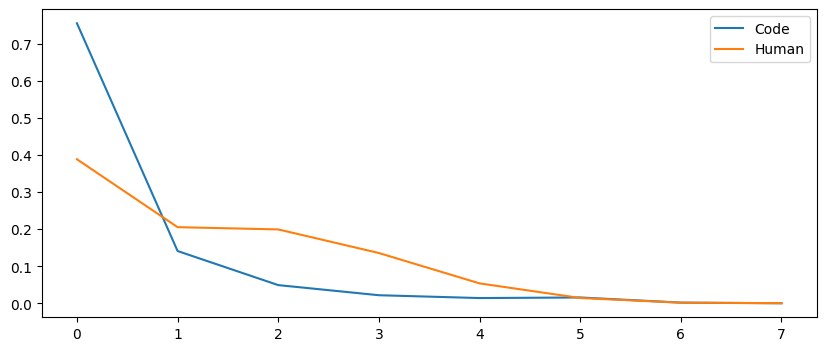

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 4))
plt.plot(bins[:-1],dist,label='Code')
plt.plot(bins[:-1],text_dist,label='Human')
plt.legend()

<Figure size 1000x300 with 0 Axes>

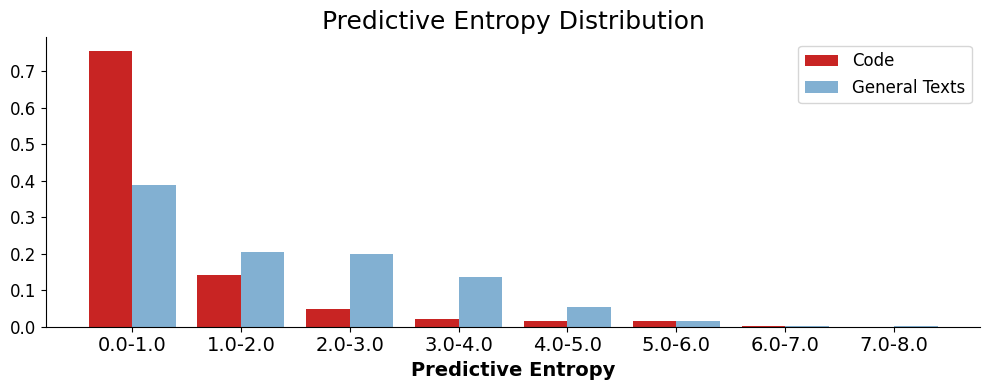

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 3))
entropy_ranges = ['0.0-1.0', '1.0-2.0', '2.0-3.0', '3.0-4.0', '4.0-5.0', '5.0-6.0', '6.0-7.0', '7.0-8.0']
code_freqs = dist
general_texts_freqs = text_dist

# Total width for all bars at one x location
total_width = 0.8
# Width of each individual bar
ind_width = total_width / 2

# Calculating the x locations for the groups
x_locs = np.arange(len(entropy_ranges))

# Defining the colors
colors = {'code': '#C82423', 'general_texts': '#82B0D2'}

# Creating the bar plot
plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
plt.bar(x_locs, code_freqs, width=ind_width, color=colors['code'], label='Code')
plt.bar(x_locs + ind_width, general_texts_freqs, width=ind_width, color=colors['general_texts'], label='General Texts')

plt.legend()
# plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Predictive Entropy', fontsize=14)
plt.title('Predictive Entropy Distribution', fontsize=18)
plt.xticks(x_locs + ind_width / 2, entropy_ranges, fontsize=14)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Setting the font style
plt.rc('font', family='serif')

# Setting the style for the plot to match the uploaded image
# plt.style.use('classic')  # 'classic' style has a similar font and background to the image
plt.style.use('bmh')
# Show plot
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_fontweight('bold')
ax.yaxis.label.set_fontweight('bold')

plt.savefig("visuals/entropy_dist.pdf",dpi=300,format='pdf')
plt.show()